In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomTranslation
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.models import Model


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

# %cd '/content/drive/MyDrive/Project Capstone'

In [3]:
# Directory Path
BASE_DIR = 'Dataset'
print(f"Base Directory: {os.listdir(BASE_DIR)}")

data_train='Dataset/train'
print(f"Data Directory: {os.listdir(data_train)}")
data_validation='Dataset/valid'
print(f"Data Directory: {os.listdir(data_validation)}")


Base Directory: ['train', 'valid']
Data Directory: ['Belimbing Sayur', 'Bunga Lawang', 'Jahe', 'Jeruk Nipis', 'Kunyit', 'Lengkuas', 'Mengkudu']
Data Directory: ['Belimbing Sayur', 'Bunga Lawang', 'Jahe', 'Jeruk Nipis', 'Kunyit', 'Lengkuas', 'Mengkudu']


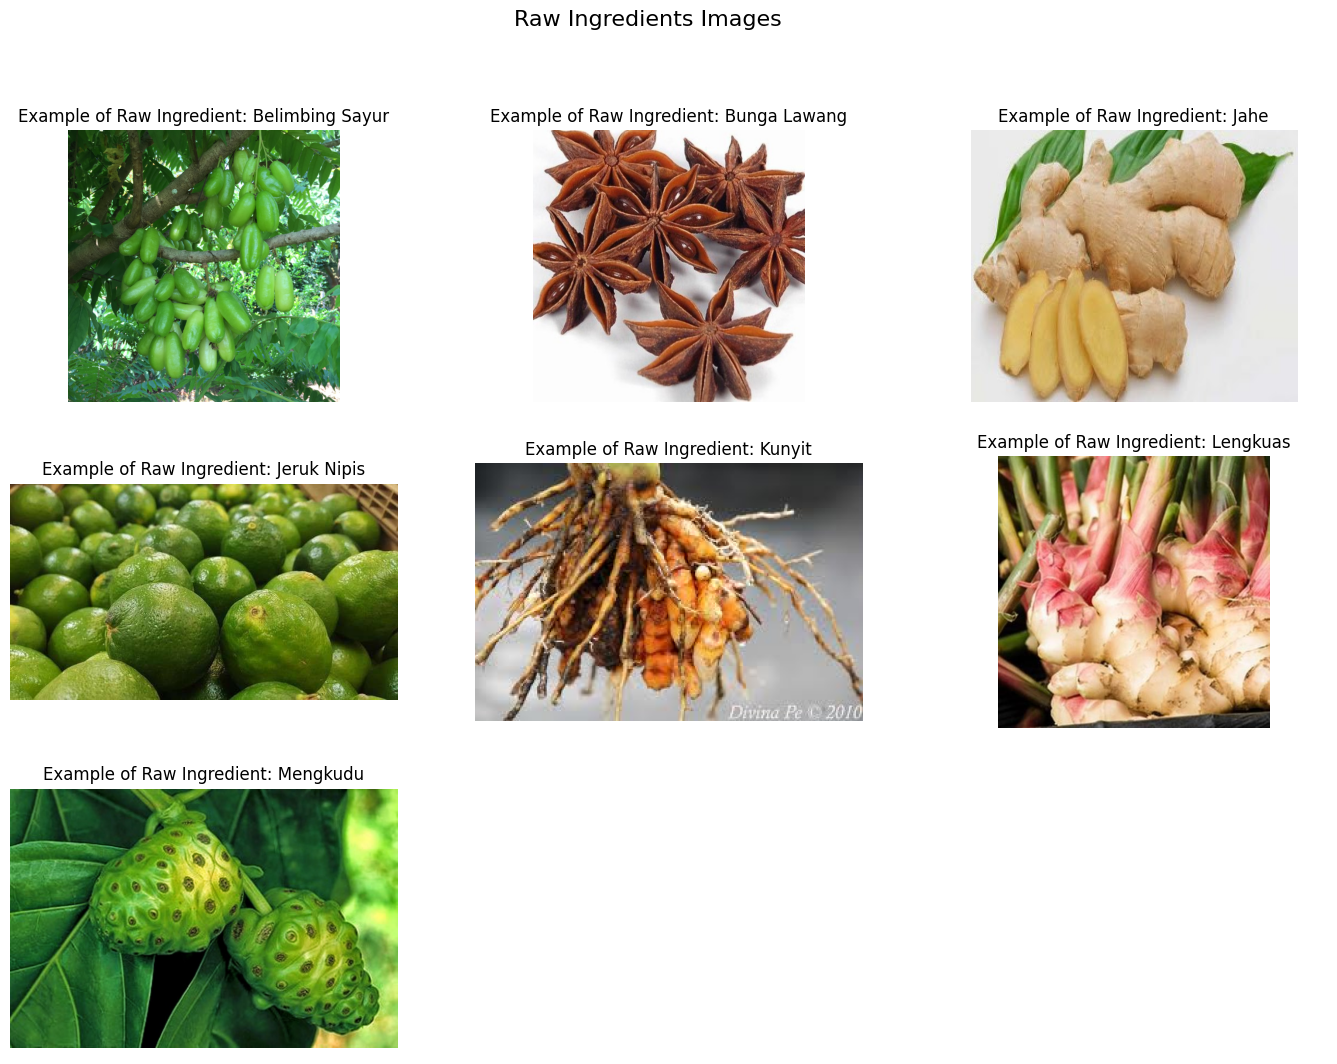

In [4]:
# Plot Raw Ingredient Images
fig, axes = plt.subplots(3, 3, figsize=(17, 12))
fig.suptitle('Raw Ingredients Images', fontsize=16)

# List of Ingredients
ingredients_list = ['Belimbing Sayur', 'Bunga Lawang', 'Jahe', 'Jeruk Nipis', 'Kunyit', 'Lengkuas', 'Mengkudu']
# Plot images for each ingredient
for ii, ingredient in enumerate(ingredients_list):
    dir_path = f'./Dataset/train/{ingredient}'
    img = tf.keras.preprocessing.image.load_img(dir_path + '/' + os.listdir(dir_path)[0])
    row, col = divmod(ii, 3)
    axes[row, col].imshow(img)
    axes[row, col].set_title(f'Example of Raw Ingredient: {ingredient}')
    axes[row, col].axis('off')

# Disable axis on empty subplots if any
for jj in range(len(ingredients_list), 9):
    row, col = divmod(jj, 3)
    axes[row, col].axis('off')

plt.show()

In [5]:
# Display Image Size
sample_array = tf.keras.preprocessing.image.img_to_array(img)
print(f"Each image has size: {sample_array.shape}")


Each image has size: (1069, 1600, 3)


In [6]:
sample_array[0,:5]

array([[ 58., 134.,  59.],
       [ 58., 134.,  59.],
       [ 58., 134.,  59.],
       [ 58., 134.,  59.],
       [ 58., 134.,  59.]], dtype=float32)

In [15]:
FILL_MODE='nearest'

data_augmentation=tf.keras.Sequential([
    tf.keras.Input(shape=(300,300,3)),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2, fill_mode=FILL_MODE),
    tf.keras.layers.RandomTranslation(0.2, 0.2, fill_mode=FILL_MODE),
    tf.keras.layers.RandomZoom(0.2, fill_mode=FILL_MODE)
])

In [16]:
def demo_augmentation(sample_image, model, num_aug):
    '''Takes a single image array, then uses a model to generate num_aug transformations'''

    # Instantiate preview list
    #simapan gambar asli dan hasil aumgmentasi 
    #biar bisa dilihat perbanndingannya
    image_preview = []

    # Convert input image to a PIL image instance
    # mengubah array gambar menjadi objek gambar PIL
    sample_image_pil = tf.keras.utils.array_to_img(sample_image)

    # Append the result to the list
    image_preview.append(sample_image_pil)

    # Apply the image augmentation and append the results to the list
    for i in range(NUM_AUG): #dilakukan augmentasi num_aug kali
        # Menambahkan dimensi ekstra pada gambar agar sesuai dengan input model augmentasi.
        sample_image_aug = model(tf.expand_dims(sample_image, axis=0))
        #gambar di convert ke PIL
        sample_image_aug_pil = tf.keras.utils.array_to_img(tf.squeeze(sample_image_aug))
        image_preview.append(sample_image_aug_pil)

    # Instantiate a subplot
    fig, axes = plt.subplots(1, NUM_AUG + 1, figsize=(12, 12))

    # Preview the images.
    for index, ax in enumerate(axes):
        ax.imshow(image_preview[index])
        ax.set_axis_off()

        if index == 0:
            ax.set_title('original')
        else:
            ax.set_title(f'augment {index}')

In [17]:
# Get a batch of images untuk lihat beberapa gambar yang bisa di augmentasikan
sample_batch = list(train_dataset.take(1))[0][0]
print(f'images per batch: {len(sample_batch)}')

images per batch: 32


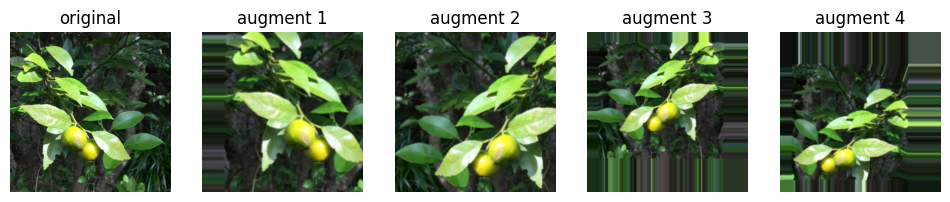

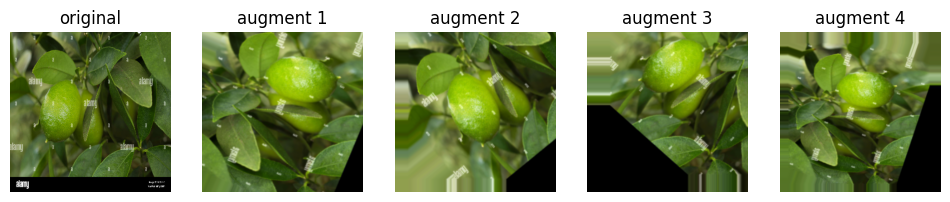

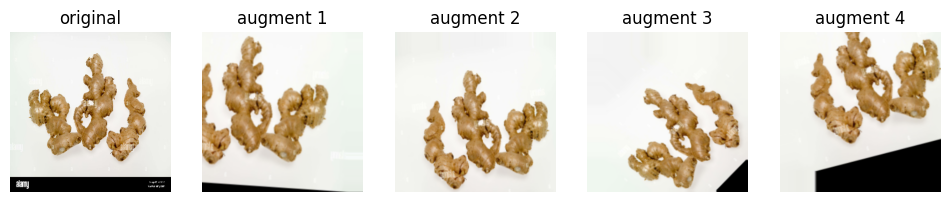

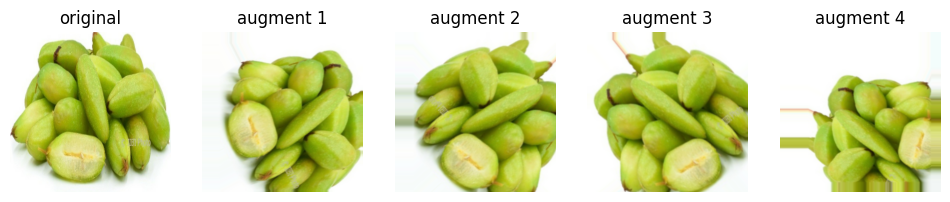

In [18]:
NUM_AUG = 4

# Apply the transformations to the first 4 images
demo_augmentation(sample_batch[0], data_augmentation, NUM_AUG)
demo_augmentation(sample_batch[1], data_augmentation, NUM_AUG)
demo_augmentation(sample_batch[2], data_augmentation, NUM_AUG)
demo_augmentation(sample_batch[3], data_augmentation, NUM_AUG)

# Uncomment the line below to delete the variable to free up some memory
# del sample_batch

In [ ]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(300, 300, 3)),
        tf.keras.layers.Rescaling(1./255),
        
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(7, activation='softmax')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [25]:
model_base=create_model()
model_base.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 300, 300, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 150, 150, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 150, 150, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 75, 75, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 37, 37, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 18, 18, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 9, 9, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 149,735 (584.90 KB)

 Trainable params: 149,735 (584.90 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:

model_with_aug=tf.keras.models.Sequential([
    data_augmentation,
    model_base
])

model_with_aug.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])


model_with_aug.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_5 (Sequential)       │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_8 (Sequential)       │ (None, 7)              │       149,735 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 149,735 (584.90 KB)

 Trainable params: 149,735 (584.90 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
BATCH_SIZE=32
IMAGE_SIZE=(300,300)
LABEL_MODE='categorical'

# Inisiasi Dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_train,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode=LABEL_MODE
    )

# Prepare the validation set
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_validation,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode=LABEL_MODE
    )


Found 2055 files belonging to 7 classes.
Found 487 files belonging to 7 classes.


In [28]:
#Optimasi
SHUFFLE_BUFFER_SIZE=500
PREFETCH_BUFFER_SIZE=tf.data.AUTOTUNE

train_dataset_final=(
    train_dataset
    .cache()
    .shuffle(SHUFFLE_BUFFER_SIZE)
    .prefetch(PREFETCH_BUFFER_SIZE)
)

validation_dataset_final=(
    validation_dataset
    .cache()
    .prefetch(PREFETCH_BUFFER_SIZE)
)

In [29]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6
)


class EarlyStoppingCallback(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
       
        train_accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')
        if train_accuracy >= 0.95 and train_accuracy >= 0.85:
            self.model.stop_training = True

            print("\nReached 95% train accuracy and 80% validation accuracy, so cancelling training!")

In [30]:

# Constant for epochs
EPOCHS = 500

# Train the model
history_aug = model_with_aug.fit(
      train_dataset_final,
      epochs=EPOCHS,
      verbose=1,
      validation_data = validation_dataset_final,
      callbacks = [EarlyStoppingCallback(), reduce_lr])

Epoch 1/500
65/65 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.1948 - loss: 1.8498 - val_accuracy: 0.2731 - val_loss: 1.3707 - learning_rate: 0.0010
Epoch 2/500
65/65 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.2834 - loss: 1.5139 - val_accuracy: 0.2977 - val_loss: 1.3160 - learning_rate: 0.0010
Epoch 3/500
65/65 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.3044 - loss: 1.4102 - val_accuracy: 0.4086 - val_loss: 1.2461 - learning_rate: 0.0010
Epoch 4/500
65/65 ━━━━━━━━━━━━━━━━━━━━ 55s 846ms/step - accuracy: 0.3831 - loss: 1.3120 - val_accuracy: 0.4415 - val_loss: 1.1604 - learning_rate: 0.0010
Epoch 5/500
65/65 ━━━━━━━━━━━━━━━━━━━━ 65s 994ms/step - accuracy: 0.4053 - loss: 1.2326 - val_accuracy: 0.4312 - val_loss: 1.2043 - learning_rate: 0.0010
Epoch 6/500
65/65 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.3977 - loss: 1.2597 - val_accuracy: 0.5318 - val_loss: 1.0654 - learning_rate: 0.0010
Epoch 7/500
65/65 ━━━━━━━━━━━━━━━━━━━━ 58s 898ms/step - accuracy: 0.4453 - loss: 1.218

KeyboardInterrupt: 